In [29]:
import pickle
import matplotlib.pyplot as plt
import torch
import io, math
import numpy as np
import zarr
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from s2aenso.utils import data, normalization, metric

model_num_swin = 547314
model_num_vit = 547313

PATH = "C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/picontrol"

val_ds_adapt = xr.open_dataset(PATH + "/evaluation/evaluation_results/data_testing/val_ds_adapt.nc")
common_lsm = xr.open_dataset(PATH + '/../../data/processed_data/enso_data_pacific/land_sea_mask_common.nc')['lsm'].data
common_lsm = common_lsm[5:57, 18:150]


zarr_pred_targ_nino_swin = zarr.open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/testing/data/preds_xr_swinlstm_{model_num_swin}.zarr", 'r')
zarr_pred_targ_nino_vit = zarr.open(f"C:/Users/felix/PycharmProjects/deeps2a-enso/scripts/testing/data/targets_xr_swinlstm_{model_num_vit}.zarr", 'r')

nino_predictions_swin = zarr_pred_targ_nino_swin["preds"]
nino_context_pred_swin = zarr_pred_targ_nino_swin["contexts_preds"]
nino_targets_swin = zarr_pred_targ_nino_swin["targs"]
nino_context_targ_swin = zarr_pred_targ_nino_swin["contexts_targs"]

nino_predictions_vit = zarr_pred_targ_nino_vit["preds"]
nino_context_pred_vit = zarr_pred_targ_nino_vit["contexts_preds"]
nino_targets_vit = zarr_pred_targ_nino_vit["targs"]
nino_context_targ_vit = zarr_pred_targ_nino_vit["contexts_targs"]

#nina_predictions_swin = zarr_pred_targ_nina_swin["preds"]
#nina_context_pred_swin = zarr_pred_targ_nina_swin["contexts_preds"]
#nina_targets_swin = zarr_pred_targ_nina_swin["targs"]
#nina_context_targ_swin = zarr_pred_targ_nina_swin["contexts_targs"]

#nina_predictions_vit = zarr_pred_targ_nina_vit["preds"]
#nina_context_pred_vit = zarr_pred_targ_nina_vit["contexts_preds"]
#nina_targets_vit = zarr_pred_targ_nina_vit["targs"]
#nina_context_targ_vit = zarr_pred_targ_nina_vit["contexts_targs"]

#neutral_predictions_swin = zarr_pred_targ_neutral_swin["preds"]
#neutral_context_pred_swin = zarr_pred_targ_neutral_swin["contexts_preds"]
#neutral_targets_swin = zarr_pred_targ_neutral_swin["targs"]
#neutral_context_targ_swin = zarr_pred_targ_neutral_swin["contexts_targs"]

#neutral_predictions_vit = zarr_pred_targ_neutral_vit["preds"]
#neutral_context_pred_vit = zarr_pred_targ_neutral_vit["contexts_preds"]
#neutral_targets_vit = zarr_pred_targ_neutral_vit["targs"]
#neutral_context_targ_vit = zarr_pred_targ_neutral_vit["contexts_targs"]

In [30]:
print(nino_predictions_swin[3].shape)

sample_pred_swin = nino_predictions_swin[3]
sample_targ_swin = nino_targets_swin[3]

sample_pred_vit = nino_predictions_vit[3]
sample_targ_vit = nino_targets_vit[3]


(8, 20, 52, 132)


C:\Users\felix\AppData\Local\Temp\ipykernel_24084\2956499332.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


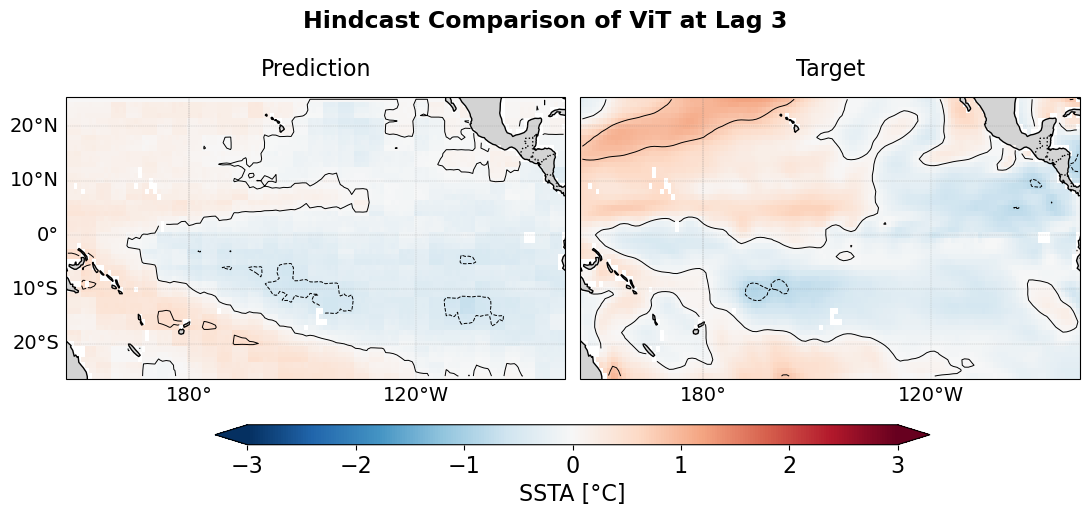

C:\Users\felix\AppData\Local\Temp\ipykernel_24084\2956499332.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


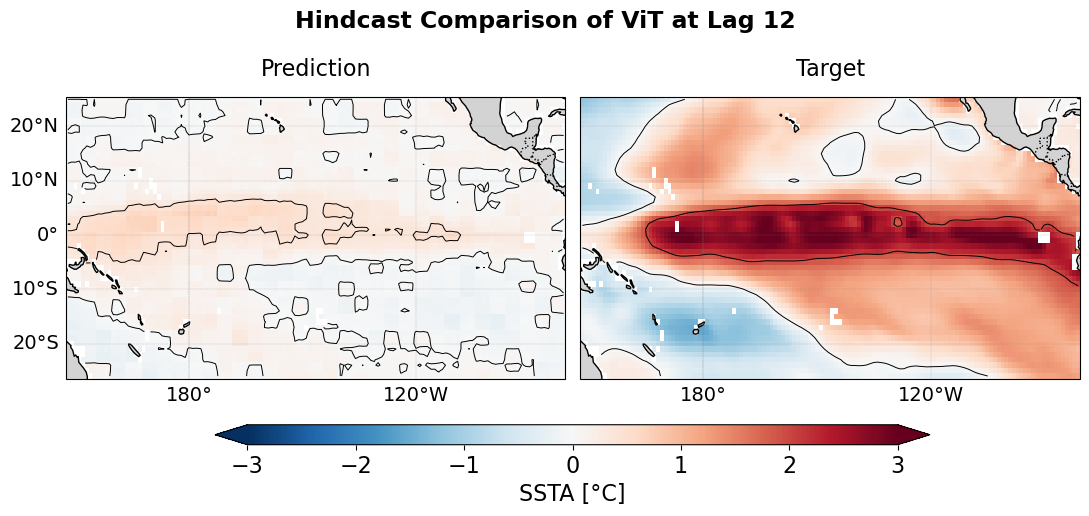

C:\Users\felix\AppData\Local\Temp\ipykernel_24084\2956499332.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.93])


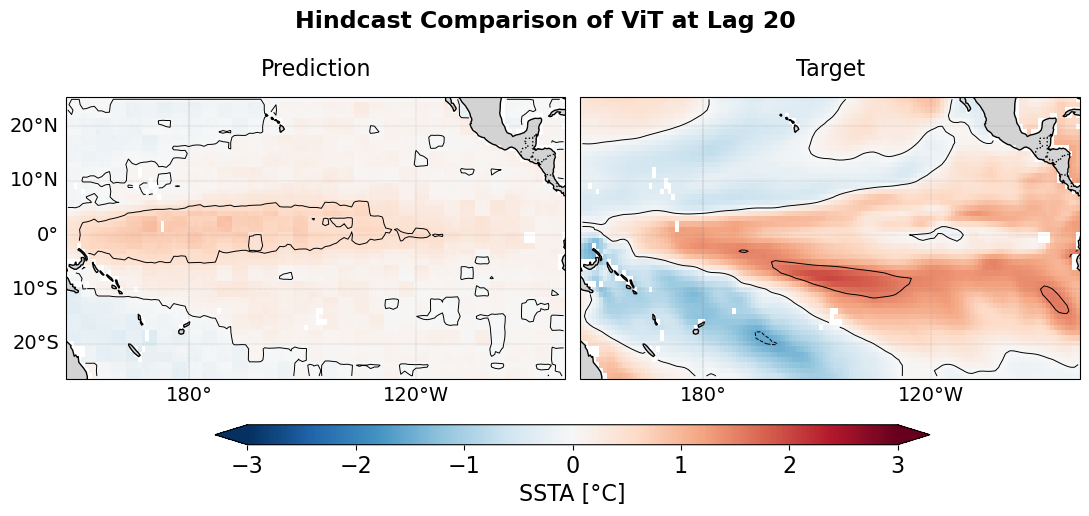

ValueError: conflicting sizes for dimension 'lat': length 10 on the data but length 52 on coordinate 'lat'

In [31]:
lags = [3, 12, 20]
for model_name in ["ViT", "SwinLSTM"]:

    if model_name == "ViT":
        prediction = torch.from_numpy(np.asarray(sample_pred_vit))
        target = torch.from_numpy(np.asarray(sample_targ_vit))
    else:
        prediction = torch.from_numpy(np.asarray(sample_pred_swin))
        target = torch.from_numpy(np.asarray(sample_targ_swin))

    for lag in lags:

        hindcast = dict()
        for key, x in dict(Prediction=prediction[:, :, :, :].unsqueeze(1), Target=target[:, :, :, :].unsqueeze(1)).items():

            x_lst = []
            x = x.cpu()
            for i, var in enumerate(val_ds_adapt.data_vars):
                da = xr.DataArray(
                    data=x[:, i, lag - 1],
                    coords=val_ds_adapt.isel(time=[1, 2, 3, 4, 5, 6, 7, 8]).coords,
                    name=var)

                # Mask land
                da = da.where(common_lsm == 0, other=np.nan)

                # Add to list
                x_lst.append(da)
                break
            hindcast[key] = xr.merge(x_lst)

        # Create a figure with 2 subplots sharing the same colorbar and projection
        fig, axs = plt.subplots(1, 2, figsize=(11, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), 'aspect': 'auto'})

        # Define a list of keys, titles, and colorbar parameters
        keys = ['Prediction', 'Target']
        titles = ['Prediction', 'Target']
        cmap = 'RdBu_r'
        vmin = -3
        vmax = 3

        # Flatten the axes array for easier iteration
        axs = axs.ravel()

        for ax, key, title in zip(axs, keys, titles):
            x = hindcast[key]
            for var in x.data_vars:
                im = ax.pcolormesh(x.lon, x.lat, x[var].isel(time=0), cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
                ax.coastlines()
                ax.set_title(title, fontsize=16, pad=15)  # Adjusted padding for subplot titles
                ax.add_feature(cfeature.BORDERS, linestyle=':')
                ax.add_feature(cfeature.LAND, facecolor='lightgray')
                gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), linewidth=0.3, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False  # Remove x-labels from the top
                gl.right_labels = False  # Remove y-labels from the right
                gl.xlabel_style = {'fontsize': 14}  # Increase x-label font size
                gl.ylabel_style = {'fontsize': 14}  # Increase y-label font size
                if ax == axs[1]:  # For the second subplot (right), remove y-labels
                    gl.left_labels = False  # Remove y-labels from the left side of the second plot

                # Add contour lines
                ax.contour(x.lon, x.lat, x[var].isel(time=0), levels=2, colors='black', linewidths=0.7, transform=ccrs.PlateCarree())

        # Add a shared colorbar below the plots
        cbar_ax = fig.add_axes([0.2, 0.05, 0.65, 0.04])  # Decreased the space between colorbar and plots
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
        cbar.set_label('SSTA [°C]', fontsize=16)
        cbar.ax.tick_params(labelsize=16)

        # Add a main title for the entire figure
        fig.suptitle(f'Hindcast Comparison of {model_name} at Lag {lag}', fontsize=17, fontweight='bold', y=0.92)  # Adjusted to bring suptitle closer to plots

        # Improve layout, reduce space around plots and suptitle
        plt.tight_layout(rect=[0, 0.1, 1, 0.93])
        
        plt.show()